In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import scipy
import cv2
import math
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray
from skimage.io import imread

## **Experiment 1 - Low pass Gaussian filter**

In [ ]:
reference_image = rgb2gray(imread('img167.bmp'))*255
noisy_images = []

noisy_image_1 = rgb2gray(imread('img125.bmp'))*255
noisy_images.append(noisy_image_1)

noisy_image_2 = rgb2gray(imread('img6.bmp'))*255
noisy_images.append(noisy_image_2)

noisy_image_3 = rgb2gray(imread('img108.bmp'))*255
noisy_images.append(noisy_image_3)

noisy_image_4 = rgb2gray(imread('img32.bmp'))*255
noisy_images.append(noisy_image_4)

noisy_image_5 = rgb2gray(imread('img137.bmp'))*255
noisy_images.append(noisy_image_5)

noisy_images = np.array(noisy_images)

In [80]:
std_dev_list = [0.1, 1, 2, 4, 8]

MSE_list = np.zeros((5,5))
SSIM_list = np.zeros((5,5))

best_sigma_mse = np.zeros(len(noisy_images))
best_sigma_ssim = np.zeros(len(noisy_images))

best_denoised_images = []

for i,noisy_image in enumerate(noisy_images):

    for j,std_dev in enumerate(std_dev_list):

        denoised_image = cv2.GaussianBlur(noisy_image, ksize = (11,11), sigmaX = std_dev)

        # FSCS
        denoised_image -= np.min(denoised_image)
        denoised_image *= (255 / np.max(denoised_image))

        mse_denoised_image = mean_squared_error(denoised_image/255, reference_image/255)
        ssim_denoised_image = ssim(denoised_image/255, reference_image/255, gradient=False)

        MSE_list[i,j] = mse_denoised_image
        SSIM_list[i,j] = ssim_denoised_image


    best_sigma_mse[i] = std_dev_list[np.argmin(MSE_list[i,:])]
    best_sigma_ssim[i] = std_dev_list[np.argmax(SSIM_list[i,:])]

    best_denoised_images.append(cv2.GaussianBlur(noisy_image, ksize = (11,11), sigmaX = best_sigma_ssim[-1]))


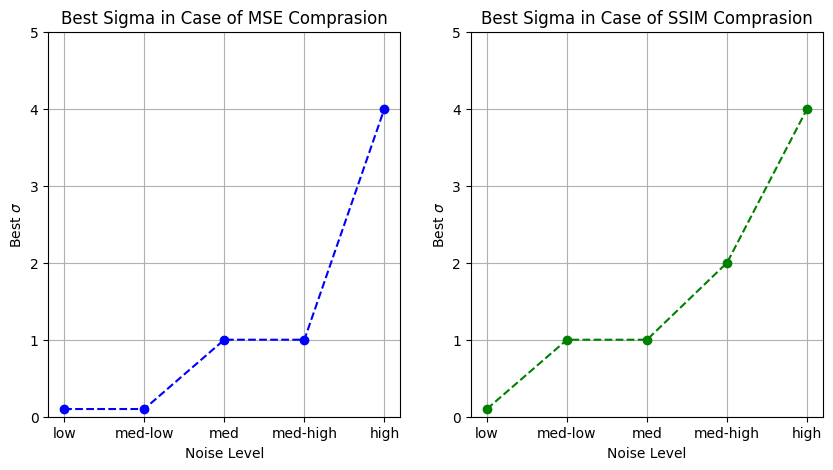

In [81]:
noise_levels = ['low', 'med-low', 'med', 'med-high', 'high']


plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(noise_levels, best_sigma_mse, '--o', color = 'blue')
plt.title('Best Sigma in Case of MSE Comprasion')
plt.xlabel('Noise Level')
plt.ylabel('Best $\sigma$')
plt.ylim(top = 5, bottom=0)
plt.grid()

plt.subplot(1,2,2)
plt.plot(noise_levels, best_sigma_ssim, '--o', color = 'green')
plt.title('Best Sigma in Case of SSIM Comprasion')
plt.xlabel('Noise Level')
plt.ylabel('Best $\sigma$')
plt.ylim(top = 5, bottom=0)
plt.grid()

In [ ]:
plt.figure(figsize = (20,30))

plt.subplot(6,2,(1,2))
plt.imshow(reference_image, cmap='gray')
plt.title('Reference Image')
plt.axis('off')
k=0
for i,images in enumerate(noisy_images):

    plt.subplot(6,2,3+k)

    plt.imshow(noisy_images[i],  cmap='gray')
    plt.title(f'Noisy Image, Noise Level: {noise_levels[i]}')
    plt.axis('off')

    plt.subplot(6,2,3+k+1)
    plt.imshow(best_denoised_images[i],  cmap='gray')
    plt.title(f'Denoised Image, sigma : {best_sigma_ssim[i]}')
    plt.axis('off')
    k+=2


Output hidden; open in https://colab.research.google.com to view.

## **Experiment 2 - Bilateral filter**

In [ ]:
noisybook = imread('noisybook.png')

In [ ]:
def denoise_bilateral(I,Kg,Kh,sigma_g,sigma_h,window_size):

  x = np.arange(-int(window_size/2),int(window_size/2)+1,1)
  y = np.arange(-int(window_size/2),int(window_size/2)+1,1)

  xv,yv = np.meshgrid(x,y)

  G = Kg*np.exp(-(xv**2+yv**2)/(2*sigma_g**2))

  def bilateral(k):
    return Kh*math.exp(-k**2/(2*sigma_h**2))

  def get_image_patch(I,i,j):
    image_patch = np.zeros((window_size,window_size))
    for m in range(window_size):
      for n in range(window_size):
        if (i+m-(window_size//2)>=0 and i+m-(window_size//2)<=len(I)-1) and (j+n-(window_size//2)>=0 and j+n-(window_size//2)<=len(I[0])-1):
          image_patch[m][n] = I[i+m-window_size//2][j+n-window_size//2]
        else:
          image_patch[m][n] = 0
    return image_patch

  J = np.zeros((len(I),len(I[0])))

  for i in range(len(I)):
    for j in range(len(I[0])):

      image_patch = get_image_patch(I,i,j)

      H_values = image_patch - image_patch[window_size//2][[window_size//2]]
      H = Kh*np.exp(-(H_values**2)/(2*sigma_h**2))

      GH = G*H
      GH = GH/np.sum(GH)


      J[i][j] = np.sum(image_patch * GH)

  J = J - np.min(J)
  J = np.array(np.round(J*255/np.max(J)),dtype='int')

  return J

In [ ]:
filtered_noisybook_bilateral = denoise_bilateral(noisybook,1,1,100,50,11)
filtered_noisybook_gaussian = cv2.GaussianBlur(noisybook, ksize = (5,5), sigmaX = 100)

(-0.5, 687.5, 687.5, -0.5)

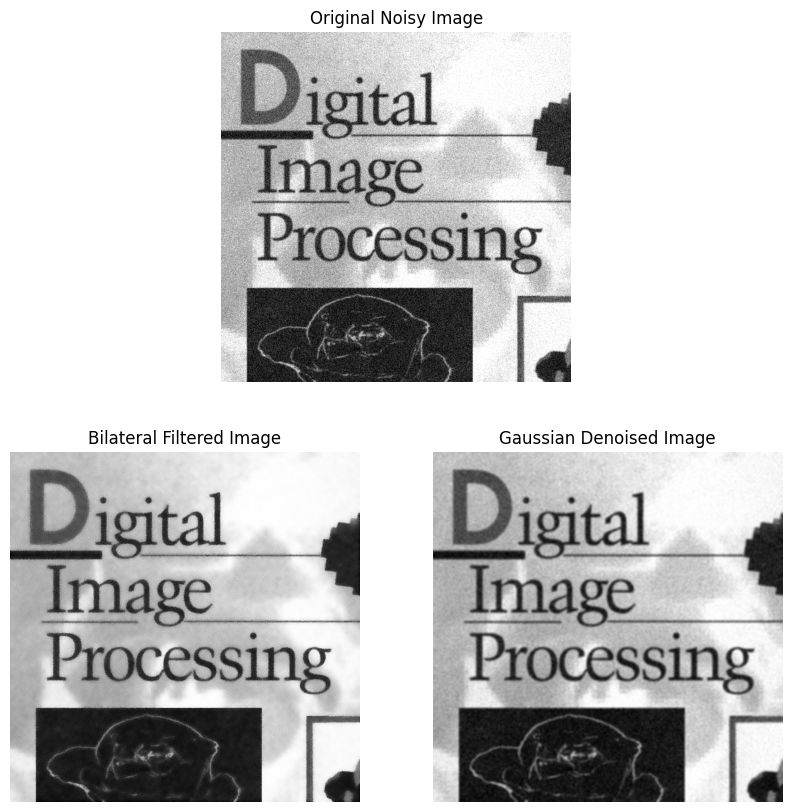

In [ ]:
plt.figure(figsize = (10,10))

plt.subplot(2,2,(1,2))
plt.imshow(noisybook, cmap = 'gray')
plt.title('Original Noisy Image')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(filtered_noisybook_bilateral, cmap = 'gray')
plt.title('Bilateral Filtered Image')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(filtered_noisybook_gaussian, cmap = 'gray')
plt.title('Gaussian Denoised Image')
plt.axis('off')